In [186]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import json
import sys
from scipy import stats
from sklearn.cross_validation import *

%matplotlib inline

In [446]:
matchup_df = pd.read_csv("temp_matchupdf.csv")

In [447]:
matchup_df.columns

Index([u'AB', u'H', u'PA', u'RL', u'SAC', u'SO', u'TB', u'W', u'bID',
       u'matchID', u'pID', u'ov_AB', u'ov_H', u'ov_PA', u'ov_SAC', u'ov_SO',
       u'ov_TB', u'ov_W', u'ov_FACED', u'ov_AVG', u'ov_OBP', u'ov_SO_PCT',
       u'ov_W_PCT', u'ov_H_PCT', u'ovp_AB', u'ovp_H', u'ovp_PA', u'ovp_SAC',
       u'ovp_SO', u'ovp_TB', u'ovp_W', u'ovp_FACED', u'ovp_SO_PCT',
       u'ovp_W_PCT', u'ovp_H_PCT', u'ovp_AVG', u'ovp_OBP'],
      dtype='object')

In [448]:
dftouse=matchup_df.copy()

In [449]:
dftouse.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,matchID,...,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_AVG,ovp_OBP
0,5,1,5,R,0,2,1,0,torrc001,torrc001_medlk001,...,13,297,674,97,188,0.197736,0.064581,0.237683,0.254093,0.302264
1,3,0,3,L,1,2,0,0,kinnm002,kinnm002_leita001,...,91,1023,2335,762,356,0.177112,0.131925,0.218144,0.251296,0.350069
2,6,0,6,R,0,0,0,0,telit001,telit001_felds001,...,53,556,1835,383,347,0.139523,0.096110,0.245671,0.271793,0.341782
3,6,2,6,R,0,2,4,0,telit001,telit001_grays001,...,9,189,289,71,110,0.218750,0.082176,0.204861,0.223203,0.287037
4,3,0,4,R,2,3,0,1,schic002,schic002_adamt001,...,34,399,937,270,243,0.170077,0.115090,0.241262,0.272640,0.356351


In [450]:
dftouse.dtypes

AB              int64
H               int64
PA              int64
RL             object
SAC             int64
SO              int64
TB              int64
W               int64
bID            object
matchID        object
pID            object
ov_AB           int64
ov_H            int64
ov_PA           int64
ov_SAC          int64
ov_SO           int64
ov_TB           int64
ov_W            int64
ov_FACED        int64
ov_AVG        float64
ov_OBP        float64
ov_SO_PCT     float64
ov_W_PCT      float64
ov_H_PCT      float64
ovp_AB          int64
ovp_H           int64
ovp_PA          int64
ovp_SAC         int64
ovp_SO          int64
ovp_TB          int64
ovp_W           int64
ovp_FACED       int64
ovp_SO_PCT    float64
ovp_W_PCT     float64
ovp_H_PCT     float64
ovp_AVG       float64
ovp_OBP       float64
dtype: object

In [451]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [452]:
print(dftouse.columns)

Index([u'AB', u'H', u'PA', u'RL', u'SAC', u'SO', u'TB', u'W', u'bID',
       u'matchID', u'pID', u'ov_AB', u'ov_H', u'ov_PA', u'ov_SAC', u'ov_SO',
       u'ov_TB', u'ov_W', u'ov_FACED', u'ov_AVG', u'ov_OBP', u'ov_SO_PCT',
       u'ov_W_PCT', u'ov_H_PCT', u'ovp_AB', u'ovp_H', u'ovp_PA', u'ovp_SAC',
       u'ovp_SO', u'ovp_TB', u'ovp_W', u'ovp_FACED', u'ovp_SO_PCT',
       u'ovp_W_PCT', u'ovp_H_PCT', u'ovp_AVG', u'ovp_OBP'],
      dtype='object')


In [453]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all conglomerations recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    nldf=ldf.copy()
    Np
    #Conglomerate pitcher stats
    nldf.set_index(['pID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ovp_'+col] = ldfp[col].sum()
    nldf['ovp_AVG'] = nldf['ovp_H']/nldf['ovp_AB']
    nldf['ovp_FACED']= ldfp.AB.count()
    nldf['ovp_OBP'] = (nldf['ovp_H'] + nldf['ovp_W'])/nldf['ovp_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ovp_' + col + '_PCT'] = nldf['ovp_' + col] / nldf['ovp_PA']
    nldf.reset_index(inplace=True)
    
    #Conglomerate batter stats
    nldf.set_index(['bID'], inplace=True)
    for col in ['AB', 'PA', 'H', 'TB', 'SAC', 'SO', 'W']:
        nldf['ov_'+col] = ldfb[col].sum()
    nldf['ov_AVG'] = nldf['ov_H']/nldf['ov_AB']
    nldf['ov_FACED']= ldfb.AB.count()
    nldf['ov_OBP'] = (nldf['ov_H'] + nldf['ov_W'])/nldf['ov_PA']
    for col in ['SO', 'W', 'H']:
        nldf['ov_' + col + '_PCT'] = nldf['ov_' + col] / nldf['ov_PA']
    nldf.reset_index(inplace=True)
    return nldf

In [454]:
def make_smaller(df, pacountp, pacountb):
    smallidf1=df[(df.ovp_PA > pacountp) & (df.ov_PA > pacountb)]
    smalldf=recompute_frame(smallidf1)
    return smalldf

In [455]:
def make_smaller_2(df, col, limit, greater=True):
    if greater:
        smallidf = df[(df[col] > limit)]
    else:
        smallidf = df[(df[col] < limit)]
    return recompute_frame(smallidf)

##Shrink dataset: Minimum plate-appearances per matchup, and PA per batter/pitcher

In [456]:
#Set minimum number of times batter/pitcher faced each other
smalldf = make_smaller_2(dftouse, 'PA', 7)

#Set minimum number of total plate appearances for batter and pitcher
smalldf = make_smaller(smalldf, 400, 400)

smalldf.to_csv('small.csv', index=False)

In [457]:
smalldf

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SAC,ovp_SO,ovp_TB,ovp_W,ovp_FACED,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_AVG,ovp_OBP
0,tejar001,alvah001,10,2,13,R,0,1,2,3,...,8,142,553,84,86,0.124671,0.073749,0.248464,0.268246,0.322212
1,tejar001,bumgm001,10,1,10,L,0,3,1,0,...,21,450,943,157,133,0.209302,0.073023,0.234419,0.252885,0.307442
2,tejar001,burna001,9,1,9,R,0,3,1,0,...,89,1630,3477,889,404,0.204774,0.111683,0.225628,0.253995,0.337312
3,tejar001,cainm001,13,5,14,R,0,4,9,1,...,61,954,2350,539,257,0.182409,0.103059,0.221989,0.247495,0.325048
4,tejar001,corrk001,10,3,10,R,0,0,7,0,...,37,512,1969,351,242,0.132883,0.091098,0.263431,0.289834,0.354529
5,tejar001,dempr002,8,4,8,R,1,0,6,0,...,72,1285,3308,883,373,0.182580,0.125462,0.240267,0.274736,0.365729
6,tejar001,detwr001,9,3,9,L,1,1,7,0,...,8,114,435,87,71,0.128090,0.097753,0.258427,0.286426,0.356180
7,tejar001,dukez001,7,2,8,L,0,0,2,1,...,37,354,1785,253,203,0.108689,0.077679,0.294750,0.319574,0.372429
8,tejar001,eovan001,12,3,14,R,0,1,5,2,...,8,138,457,96,70,0.144050,0.100209,0.254697,0.283063,0.354906
9,tejar001,franj003,7,3,8,L,0,1,5,1,...,38,475,1864,331,227,0.135792,0.094626,0.265866,0.293653,0.360492


In [406]:
print "Number of Matchups",smalldf.shape[0]
print "Number of Batters", smalldf.bID.unique().shape[0]
print "Number of Pitchers", smalldf.pID.unique().shape[0]
s,d=compute_supports(smalldf)

Number of Matchups 95982
Number of Batters 684
Number of Pitchers 819
mean support 27.6440557541 median support 17.0


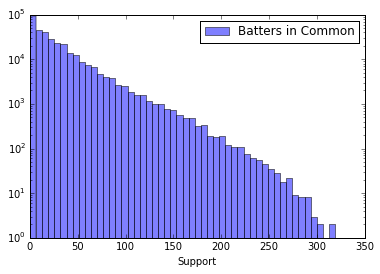

In [407]:
plt.hist(s, bins=50, alpha=0.5, label="Batters in Common", log=True);
plt.xlabel('Support')
plt.legend();
plt.show()

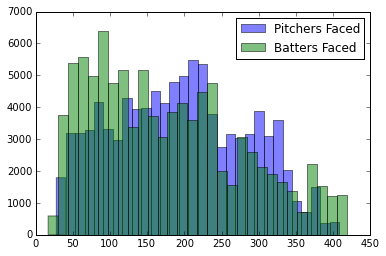

In [408]:
plt.hist(smalldf.ov_FACED, bins=30, alpha=0.5, label='Pitchers Faced')
plt.hist(smalldf.ovp_FACED, bins=30, alpha=0.5, label='Batters Faced')
plt.legend();
plt.show()

In [409]:
print smalldf.shape
smalldf=smalldf.drop_duplicates(['bID','pID'])
print smalldf.shape
#smalldf.dtypes
smalldf.head(5)

(95982, 35)
(95982, 35)


,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_AB,ovp_H,ovp_W,ovp_TB,ovp_PA,ovp_AVG,ovp_OBP,matchID,ovp_FACED,ov_FACED
0,tejar001,alvah001,10,2,13,R,0,1,2,3,...,1641,454,118,854,1139,0.268246,0.322212,tejar001_alvah001,86,55
1,tejar001,bumgm001,10,1,10,L,0,3,1,0,...,3044,760,246,1423,2150,0.252885,0.307442,tejar001_bumgm001,133,55
2,tejar001,burna001,9,1,9,R,0,3,1,0,...,8536,2134,1075,4082,7960,0.253995,0.337312,tejar001_burna001,404,55
3,tejar001,cainm001,13,5,14,R,0,4,9,1,...,5999,1392,640,2771,5230,0.247495,0.325048,tejar001_cainm001,257,55
4,tejar001,corrk001,10,3,10,R,0,0,7,0,...,4784,1363,466,2616,3853,0.289834,0.354529,tejar001_corrk001,242,55


#Splitting into Test and Training Sets

In [410]:
print smalldf.shape,
smalldf[smalldf.ov_FACED > 100].shape

(95982, 35)

(78047, 35)

In [411]:
trainlist=[]
testlist=[]
validatelist=[]
take=21 #11 matchups between validation and test set
for k, v in smalldf.groupby('bID'):
    if len(v) > 100: #batter has faced at least 150 pitchers
        train_rows, test_valid_rows = train_test_split(v, test_size=take)
        trainlist.append(train_rows)
        valid_rows, test_rows = train_test_split(test_valid_rows, test_size=0.4)
        validatelist.append(valid_rows) 
        testlist.append(test_rows) 
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(87729, 35) (4716, 35) (3537, 35)


In [412]:
#Make sure each pitcher ID was encountered in training set
maskval= np.in1d(validatedf.pID, traindf.pID) 
masktest = np.in1d(testdf.pID, traindf.pID)
print np.sum(~maskval), np.sum(~masktest)

0 0


In [413]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['bID', 'pID','AVG']]
testdf=testdf[['bID', 'pID', 'AVG']]
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_AB,ovp_H,ovp_W,ovp_TB,ovp_PA,ovp_AVG,ovp_OBP,matchID,ovp_FACED,ov_FACED
0,abreb001,kiled001,18,4,22,R,0,5,11,4,...,3796,1024,453,2014,3449,0.272816,0.353146,abreb001_kiled001,136,337
1,abreb001,jarvk001,14,3,16,R,0,4,7,2,...,1769,553,187,1262,1262,0.298494,0.372425,abreb001_jarvk001,85,337
2,abreb001,niemj001,16,3,18,R,1,4,9,2,...,1783,461,183,922,1231,0.260830,0.334687,abreb001_niemj001,89,337
3,abreb001,martd004,6,0,8,L,1,3,0,2,...,1155,265,200,482,690,0.209262,0.331884,abreb001_martd004,61,337
4,abreb001,moehb001,8,2,8,R,0,4,4,0,...,4283,1302,398,2521,3565,0.308570,0.370827,abreb001_moehb001,209,337


#The baseline model

In [414]:
ybar = traindf.H.sum() / float(traindf.AB.sum())
ybar

0.2745146914878741

In [415]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids
print ubids,upids,len(upids),len(ubids)

['abreb001' 'ackld001' 'alfoe001' 'alomr001' 'aloms001' 'alony001'
 'aloum001' 'altuj001' 'alvap001' 'amara001' 'ameza001' 'andeg001'
 'andem003' 'andir001' 'andre001' 'ankir001' 'aokin001' 'arenj001'
 'atkig001' 'aurir001' 'ausmb001' 'avila001' 'avilm001' 'aybae001'
 'baerc001' 'bagwj001' 'bakej001' 'bakop001' 'baldr001' 'barar001'
 'bardj001' 'barmc001' 'barnd001' 'barrm003' 'bartd001' 'bartj001'
 'batit001' 'bautd001' 'bautj002' 'bay-j001' 'beckg001' 'belld002'
 'bellm002' 'bellr002' 'belta001' 'beltb001' 'beltc001' 'benng001'
 'bergd002' 'bergp001' 'berkl001' 'bernr001' 'berra001' 'betay001'
 'betew001' 'bigbl001' 'biggc001' 'blakc001' 'blalh001' 'blang001'
 'blanh001' 'bloow001' 'blumg001' 'boesb001' 'bondb001' 'bonie001'
 'boona001' 'boonb002' 'bordp001' 'bourm001' 'bourp001' 'bradm001'
 'bragd001' 'branm003' 'branr001' 'braur002' 'broub001' 'browa001'
 'browd004' 'browe001' 'brucj001' 'buckj001' 'burkc001' 'burke001'
 'burnj001' 'burrp001' 'burrs001' 'bushh001' 'butlb003' 'byrdm

In [416]:
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [417]:
batter_biases={}
pitcher_biases={}

for uindx, batter in enumerate(ubids):
    batter_row=traindf[traindf.bID==batter]
    yb=batter_row.ov_AVG.unique()[0]
    bbaseline = yb - ybar
    batter_biases[batter]=bbaseline

for iindx, pit in enumerate(upids):
    pit_row=traindf[traindf.pID==pit]
    yp=pit_row.ovp_AVG.unique()[0]
    pbaseline = yp - ybar
    pitcher_biases[pit]=pbaseline

In [418]:
pitcher_biases

{'abboj001': 0.020827231207864227,
 'abbop001': -0.012699946686361818,
 'aceva001': -0.030558647531830158,
 'acevj001': 0.015520895700738002,
 'acevj002': 0.042828481943860186,
 'adamt001': 0.0023969640429351013,
 'affej001': -0.020123019399390041,
 'aguir001': 0.0025123355391529212,
 'albem001': -0.0036813581545407925,
 'alfoa001': 0.025727439262731244,
 'alvah001': -0.009229717394609871,
 'alvaw001': -0.0088896914878741073,
 'andeb002': 0.035271662750582133,
 'andeb004': 0.0062678171427357765,
 'andej002': 0.046437689464506826,
 'appik001': 0.00046939508119020479,
 'archc001': -0.020726812699995323,
 'armat002': 0.00182939453363129,
 'arrij001': -0.0050911325906309868,
 'arrob001': 0.0053570005730721459,
 'arror001': 0.004358547948745628,
 'ashba002': 0.0083728130925582733,
 'assep001': -0.005728564320244045,
 'astap001': 0.028558729115426951,
 'avers001': 0.0056747323479585665,
 'ayall001': 0.042255494847529607,
 'aybam001': -0.012786296426145705,
 'backb001': 0.033729036110692223,


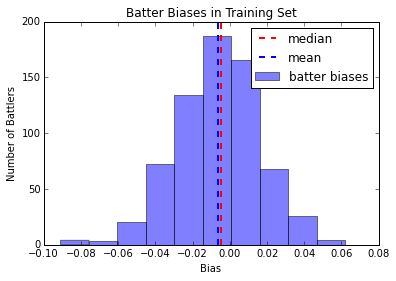

In [419]:
plt.hist(batter_biases.values(), alpha=0.5, label="batter biases");
plt.xlabel('Bias')
plt.ylabel('Number of Battlers')
plt.title('Batter Biases in Training Set')
plt.axvline(np.median(batter_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(np.mean(batter_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

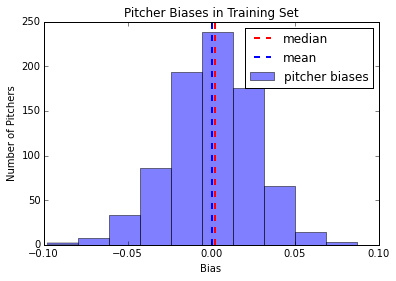

In [420]:
plt.hist(pitcher_biases.values(), alpha=0.5, label="pitcher biases");
plt.xlabel('Bias')
plt.ylabel('Number of Pitchers')
plt.title('Pitcher Biases in Training Set')
plt.axvline(x=np.median(pitcher_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(x=np.mean(pitcher_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

In [421]:
train_avgs={'mean':ybar, 'batters':batter_biases, 'pitchers':pitcher_biases}

In [422]:
train_avgs['batters']

{'abreb001': 0.013638990475839885,
 'ackld001': -0.019013468993986593,
 'alfoe001': 0.0099024145461036328,
 'alomr001': 0.028576583434386738,
 'aloms001': 0.0013812338925873746,
 'alony001': 0.0073645031429983576,
 'aloum001': 0.017673876036607805,
 'altuj001': 0.026037794699971195,
 'alvap001': -0.028794651205900301,
 'amara001': -0.03026181792465571,
 'ameza001': -0.007681773782138468,
 'andeg001': 0.014650891117589548,
 'andem003': -0.021181358154540753,
 'andir001': -0.017429671244959144,
 'andre001': -0.012475917253977897,
 'ankir001': -0.018546521726600873,
 'aokin001': 0.017564516432917954,
 'arenj001': -0.08962723168080014,
 'atkig001': 0.010410328243775469,
 'aurir001': -0.00056305389987287846,
 'ausmb001': -0.031676320922828127,
 'avila001': -0.029231672619949578,
 'avilm001': -0.013834656614290841,
 'aybae001': 0.004111262710599195,
 'baerc001': 0.017810364945534451,
 'bagwj001': 0.018497639692395984,
 'bakej001': 0.046728831828188044,
 'bakop001': -0.015302493266781347,
 'b

In [431]:
predictions={'universal':ybar+np.zeros(len(testdf))}
predictions_valid={'universal':ybar+np.zeros(len(validatedf))}

In [432]:
#your code here
####

#initializing list
list_pred=[]

#for each row in test df:
for row in range(len(testdf)):
    batterid_test=testdf.iloc[row]['bID'] #get the batter
    pitcherid_test=testdf.iloc[row]['pID'] #get the restuarant id
    list_pred.append(ybar+batter_biases[batterid_test]+pitcher_biases[pitcherid_test]) #call biases and calc. pred.
    predictions["baseline"]=list_pred #add to dictionary
print len(predictions['baseline'])

#initializing list
list_pred2=[]
#for each row in validate df:
for row in range(len(validatedf)):
    batterid_val=validatedf.iloc[row]['bID'] #get the batter
    pitcherid_val=validatedf.iloc[row]['pID'] #get the restuarant id
    list_pred2.append(ybar+batter_biases[batterid_val]+pitcher_biases[pitcherid_val])#call biases and calc. pred.
    predictions_valid["baseline"]=list_pred2 #add to dictionary
print len(predictions_valid['baseline'])

3537
4716


In [433]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.sum(diff**2)/len(diff))

In [434]:
predictions['universal']

array([ 0.27451469,  0.27451469,  0.27451469, ...,  0.27451469,
        0.27451469,  0.27451469])

In [427]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=np.round(avg_actual, decimals=2), predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline 0.133260802525


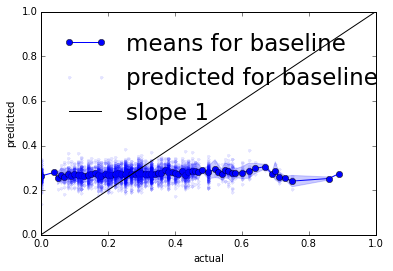

In [436]:
compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True);